In [1]:
from autoemulate.experimental.sensitivity_analysis import SensitivityAnalysis
from autoemulate.experimental.compare import AutoEmulate
from autoemulate.experimental.emulators import *
from autoemulate.experimental.simulations.flow_problem import FlowProblem
from autoemulate.experimental.simulations.projectile import ProjectileMultioutput

In [2]:
param_ranges = {"T": (0.5, 2.0),
                "td": (0.1, 0.5),
                "amp": (100.0, 1000.0),
                "dt": (0.0001, 0.01),
                "C": (20.0, 60.0),
                "R": (0.01, 0.1),
                "L": (0.001, 0.005),
                "R_o": (0.01, 0.05),
                "p_o": (5.0, 15.0)}
output_names = ["pressure"]

simulator = FlowProblem(
    param_ranges=param_ranges,
    output_names=output_names,
)

In [3]:
x = simulator.sample_inputs(100)
y = simulator.forward_batch(x)

Running simulations: 100%|██████████| 100/100 [00:41<00:00, 2.42sample/s] 


In [5]:
x.shape, y.shape

(torch.Size([100, 9]), torch.Size([100, 20]))

In [4]:
print(simulator.in_dim)
print(simulator.param_names)
print(simulator.param_bounds)
print(simulator.output_names)

9
['T', 'td', 'amp', 'dt', 'C', 'R', 'L', 'R_o', 'p_o']
[(0.5, 2.0), (0.1, 0.5), (100.0, 1000.0), (0.0001, 0.01), (20.0, 60.0), (0.01, 0.1), (0.001, 0.005), (0.01, 0.05), (5.0, 15.0)]
['pressure']


In [6]:
ae = AutoEmulate(x, y, models=[RandomForest])

Comparing models: 100%|██████████| 1.00/1.00 [00:06<00:00, 6.00s/model]


In [7]:
best = ae.best_result()
model = best.model

In [8]:
problem = {
    'num_vars': simulator.in_dim,
    'names': simulator.param_names,
    'bounds': simulator.param_bounds,
    'output_names': simulator.output_names,
    }
sa = SensitivityAnalysis(model, problem=problem)

In [14]:
sobol_df = sa.run("sobol")
sobol_df

,output,parameter,index,value,confidence
0,pressure,T,S1,0.280517,0.034613
1,pressure,td,S1,0.176714,0.016162
2,pressure,amp,S1,0.317716,0.034901
3,pressure,dt,S1,0.000713,0.000093
4,pressure,C,S1,0.001446,0.000250
5,pressure,R,S1,0.022965,0.002759
6,pressure,L,S1,0.005006,0.000652
7,pressure,R_o,S1,0.019085,0.002507
8,pressure,p_o,S1,0.277526,0.026117
0,pressure,T,ST,0.218088,0.045482


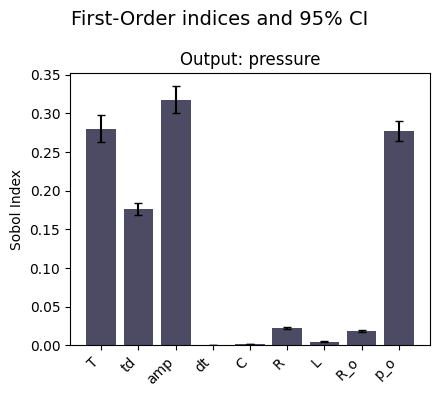

In [19]:
sa.plot_sobol(sobol_df, index="S1")